In [1]:
%matplotlib inline

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from detector_v2 import CornerDetector
from utils.centre_point_box import get_centre_point_boxex, draw_centre_points
from utils.preprocessing import warp_image_with_centres

In [3]:
detector = CornerDetector('models/corner_detector_v2.1.pt') 
detector.device_info()

Is GPU available?: True
GPU count: 1
Device name: NVIDIA GeForce GTX 1070


In [4]:
metrics = detector.evaluate('./dataset_v2/data.yaml')
print(f'\nPrecision: {metrics['mean_precision']}')
print(f'Recall: {metrics['mean_recall']}')
print(f'mAP50: {metrics['mean_mAP50']}')
print(f'mAP50-95: {metrics['mean_mAP50-95']}')

Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning F:\CV_Project\src\modules\corner_detector\dataset_v2\valid\labels.cache... 105 images, 0 backgrounds, 0 corrupt: 100%|██████████| 105/105 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]


                   all        105        402       0.94      0.934      0.948      0.505
           bottom-left        103        105      0.924      0.933      0.931      0.522
          bottom-right        102        102       0.95      0.961      0.963      0.529
              top-left        103        103      0.956      0.961      0.972      0.491
             top-right         91         92      0.931      0.879      0.927      0.478
Speed: 1.4ms preprocess, 12.1ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs\detect\val3

Precision: 0.9401036872622397
Recall: 0.9336080647920764
mAP50: 0.9479974749911609
mAP50-95: 0.5049731509326021


In [ ]:
%cd F://CV_Project/src/modules/corner_detector/
IMG_PATH = '.jpg'
img = cv2.imread(IMG_PATH)
plt.title('Original image')
plt.imshow(img[:,:,::-1])
plt.show()

F:\CV_Project\src\modules\corner_detector


FileNotFoundError: [Errno 2] No such file or directory: 'images.jpg'

In [7]:
result = detector.predict(IMG_PATH, save=True)

Results saved to runs\detect\predict3


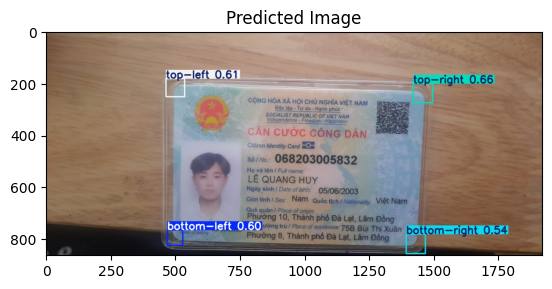

In [8]:
predicted_img = cv2.imread(os.path.join(result[0].save_dir, IMG_PATH))
plt.title('Predicted Image')
plt.imshow(predicted_img[:,:,::-1])
plt.show()

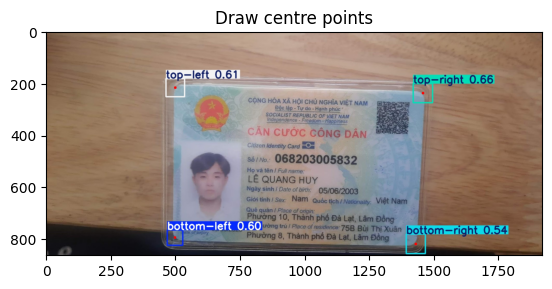

In [9]:
centre_points = get_centre_point_boxex(result[0].boxes)
drawed_img = draw_centre_points(predicted_img, centre_points)

plt.title('Draw centre points')
plt.imshow(drawed_img)
plt.show()

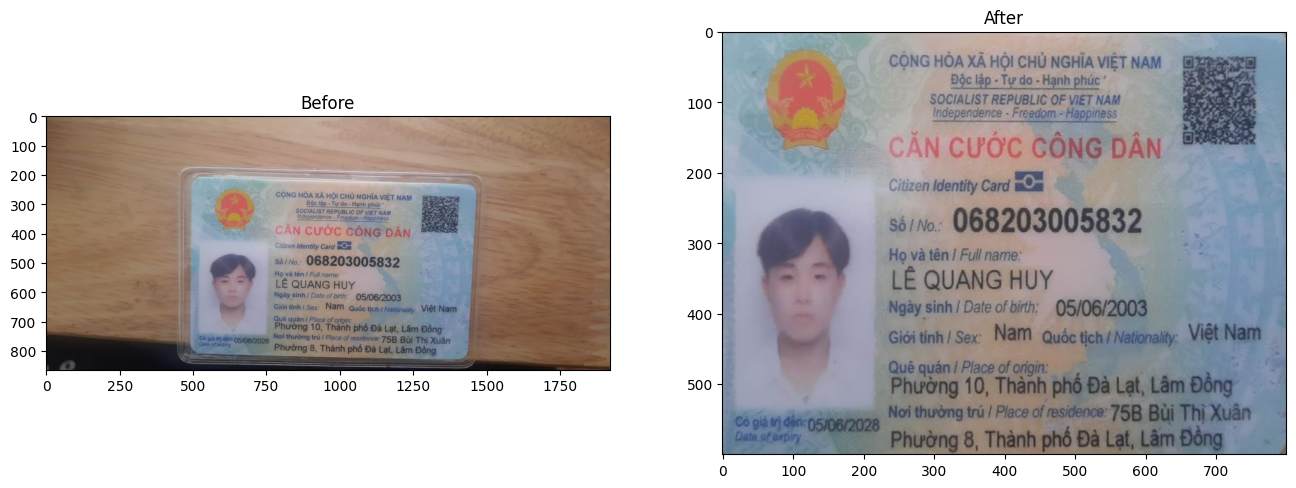

In [10]:
origin_img = cv2.imread(IMG_PATH)
wrapped_img = warp_image_with_centres(img, centre_points, output_size=(800, 600))

plt.figure(figsize=(16, 12))
plt.subplot(1, 2, 1)
plt.imshow(origin_img[:,:,::-1])
plt.title('Before')

plt.subplot(1, 2, 2)
plt.imshow(wrapped_img[:,:,::-1])
plt.title('After')

plt.show()

In [11]:
cv2.imwrite('./cccd_wrapped1.png', wrapped_img)

True